In [27]:
pd.__version__

'2.0.1'

# Running SATURN

This notebook will demonstrate how to run SATURN and review the output files.

Make sure to run through `dataloader.ipynb` first.

First, make the run csv file.

It should have format:

|path|species|embedding path|
|-----|------|--------------|
|path to frog|frog|frog embeddings path|
|path to zebrafish|zebrafish|zebrafish embeddings path|

In [1]:
# Make the csv
import pandas as pd

df = pd.DataFrame(columns=["path", "species", "embedding_path"])
df["species"] = ["human", "mouse","fly"]
df["path"] = ["data/human.h5ad", "data/mouse.h5ad", "data/fly.h5ad"]

##### CHANGE THESE PATHS #####
human_embedding_path = "/nfs/research/irene/anaelle/Scripts/SATURN/protein_embeddings/data/Homo_sapiens.GRCh38.pep.all.gene_symbol_to_embedding_ESM1b.pt"
mouse_embedding_path = "/nfs/research/irene/anaelle/Scripts/SATURN/protein_embeddings/data/Mus_musculus.GRCm39.pep.all.gene_symbol_to_embedding_ESM1b.pt"
fly_embedding_path = "/nfs/research/irene/anaelle/Scripts/SATURN/protein_embeddings/data/Drosophila_melanogaster.BDGP6.32.pep.all.gene_symbol_to_embedding_ESM1b.pt"
##############################
df["embedding_path"] = [human_embedding_path, mouse_embedding_path, fly_embedding_path]
df.to_csv("data/human_mouse_fly_run.csv", index=False)
df

,path,species,embedding_path
0,data/human.h5ad,human,/nfs/research/irene/anaelle/Scripts/SATURN/pro...
1,data/mouse.h5ad,mouse,/nfs/research/irene/anaelle/Scripts/SATURN/pro...
2,data/fly.h5ad,fly,/nfs/research/irene/anaelle/Scripts/SATURN/pro...


In [2]:
import os
os.getcwd()

'/nfs/research/irene/anaelle/Scripts/SATURN/Vignettes/frog_zebrafish_embryogenesis'

# Scoring while training

We will score our model output while training. To do that, we will need a scoring csv file. We have provided one in this dataset at `data/frog_zebrafish_cell_type_map.csv`. It looks like this:

# Train the Model

We can see `train-saturn.py`'s potential arguments with `--help`.

In [6]:
!python3 ../../train-saturn.py --help

Global seed set to 0
usage: train-saturn.py [-h] [--in_data IN_DATA] [--device DEVICE]
                       [--device_num DEVICE_NUM] [--time_stamp TIME_STAMP]
                       [--org ORG] [--log_dir LOG_DIR] [--work_dir WORK_DIR]
                       [--seed SEED] [--in_label_col IN_LABEL_COL]
                       [--ref_label_col REF_LABEL_COL]
                       [--tissue_subset TISSUE_SUBSET]
                       [--tissue_column TISSUE_COLUMN] [--hv_genes HV_GENES]
                       [--hv_span HV_SPAN] [--num_macrogenes NUM_MACROGENES]
                       [--centroids_init_path CENTROIDS_INIT_PATH]
                       [--embedding_model {ESM1b,MSA1b,protXL,ESM1b_protref,ESM2}]
                       [--centroid_score_func {default,one_hot,smoothed}]
                       [--vae [VAE]] [--hidden_dim HIDDEN_DIM]
                       [--model_dim MODEL_DIM]
                       [--binarize_expression [BINARIZE_EXPRESSION]]
                       [--s

We'll train SATURN with the following settings:

|Argument|Value|Explanation|
|--------|-----|-----------|
|in_data|`data/frog_zebrafish_run.csv`|The csv we created containing paths.|
|in_label_col|`cell_type`|Use the `cell_type` column labels for metric learning. **NOTE:** SATURN is weakly supervised, it does not share cell type labels across species, so you don't need to match these values across AnnDatas.|
|ref_label_col|`cell_type`|Extra cell type argument, will be added to our output but won't effect results since we didn't add `--use_ref_labels|
|num_macrogenes|`2000`|By default, we use 2000 macrogenes.|
|hv_genes|`8000`|By default, we use the 8000 most highly variable genes.|
|centroids_init_path|`saturn_results/fz_centroids.pkl`|Since this is the first time we are runinng this command, we will have to initialize our macrogenes using KMeans, which is an expensive operation. We save that initialization to this location so that if we pass this path to this argument in future runs, we can skip that step.|
|score_adata||By adding this flag, we will score our adatas after pretraining and while fine tuning with metric learning.|
|ct_map_path|`data/frog_zebrafish_cell_type_map.csv`|The path to our cell type mapping file, needed since we are scoring while training.|
|work_dir|`./`|SATURN outputs to a folder called `saturn_results`.|

SATURN is very verbose. Some things to check during model training:
- Do the AnnData views printed at the start have enough genes? These AnnData views are output after subsetting your input AnnDatas to just the genes that have protein embeddings.


**This command may take some time.**

GPU Memory usage: ~8GB for Pretraining, ~10GB total for metric learning but this may very.

In [3]:
!python3 ../../train-saturn.py --in_data=data/frog_zebrafish_run.csv \
                              --in_label_col=cell_type --ref_label_col=cell_type \
                              --num_macrogenes=2000     --hv_genes=8000          \
                              --centroids_init_path=saturn_results/fz_centroids.pkl \
                              --score_adata --ct_map_path=data/frog_zebrafish_cell_type_map.csv \
                              --work_dir=. \
                              --device_num=7 \

Global seed set to 0
Using Device 7
Set seed to 0
After loading the anndata frog View of AnnData object with n_obs × n_vars = 96935 × 9538
    obs: 'clusters', 'parent_clusters', 'cell_type', 'n_genes', 'species', 'species_type_label', 'truth_labels', 'ref_labels'
    var: 'n_cells'
After loading the anndata zebrafish View of AnnData object with n_obs × n_vars = 63371 × 16980
    obs: 'n_counts', 'unique_cell_id', 'cell_names', 'library_id', 'batch', 'ClusterID', 'ClusterName', 'TissueID', 'TissueName', 'TimeID', 'cluster', 'cell_type', 'n_genes', 'species', 'species_type_label', 'truth_labels', 'ref_labels'
    var: 'n_cells'
Loaded centroids
Pretraining...
Epoch 14: L1 Loss 0.0 Rank Loss 23.064104080200195, Avg Loss frog: 2143, Avg Los^C
Epoch 14: L1 Loss 0.0 Rank Loss 23.064104080200195, Avg Loss frog: 2143, Avg Los
Traceback (most recent call last):
  File "../../train-saturn.py", line 1064, in <module>
    trainer(args)
  File "../../train-saturn.py", line 654, in trainer
    pret

KeyboardInterrupt: 

In [3]:
!python3 ../../train-saturn.py --in_data=data/human_mouse_fly_run.csv --in_label_col=cell_type --ref_label_col=cell_type --work_dir=./hmf




Global seed set to 0
Traceback (most recent call last):
  File "/nfs/research/irene/anaelle/Scripts/SATURN/Vignettes/frog_zebrafish_embryogenesis/../../train-saturn.py", line 1055, in <module>
    torch.cuda.set_device(args.device_num)
  File "/nfs/research/irene/anaelle/miniconda3/lib/python3.10/site-packages/torch/cuda/__init__.py", line 314, in set_device
    torch._C._cuda_setDevice(device)
  File "/nfs/research/irene/anaelle/miniconda3/lib/python3.10/site-packages/torch/cuda/__init__.py", line 217, in _lazy_init
    torch._C._cuda_init()
RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx


# Analyze SATURN Outputs

Let's check what files SATURN outputted:

In [43]:
!ls ./hmf/saturn_results

test256_data_human_mouse_org_saturn_seed_0_celltype_id.pkl
test256_data_human_mouse_org_saturn_seed_0_ep_25.h5ad
test256_data_human_mouse_org_saturn_seed_0_ep_50.h5ad
test256_data_human_mouse_org_saturn_seed_0_epoch_scores.csv
test256_data_human_mouse_org_saturn_seed_0_genes_to_macrogenes.pkl
test256_data_human_mouse_org_saturn_seed_0.h5ad
test256_data_human_mouse_org_saturn_seed_0_pretrain.h5ad
test256_data_human_mouse_org_saturn_seed_0_triplets.csv


We have a number of log files and 
- our output AnnData: `test256_data_frog_zebrafish_org_saturn_seed_0.h5ad`
- out ouput gene to macrogene weights: `test256_data_frog_zebrafish_org_saturn_seed_0_genes_to_macrogenes.pkl`

Some additional files are also created:
- pretraining results: `test256_data_frog_zebrafish_org_saturn_seed_0_pretrain.h5ad`
- intermediate metric learning training results: `test256_data_frog_zebrafish_org_saturn_seed_0_ep_25.h5ad` and `test256_data_frog_zebrafish_org_saturn_seed_0_ep_50.h5ad` and their scores `test256_data_frog_zebrafish_org_saturn_seed_0_epoch_scores.csv`
- which triplets were mined during metric learning training: `test256_data_frog_zebrafish_org_saturn_seed_0_triplets.csv` and an accompanying dictionary file with cell type maps: `test256_data_frog_zebrafish_org_saturn_seed_0_celltype_id.pkl`
- the centroid initialization scores: `fz_centroids.pkl`

## Load SATURN Results

In [29]:
import scanpy as sc
import pickle

In [44]:
adata = sc.read("hmf/saturn_results/test256_data_human_mouse_fly_org_saturn_seed_0.h5ad")
adata

AnnData object with n_obs × n_vars = 236271 × 256
    obs: 'labels', 'labels2', 'ref_labels', 'species'
    obsm: 'macrogenes'

## Visualize our integration

/nfs/research/irene/anaelle/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


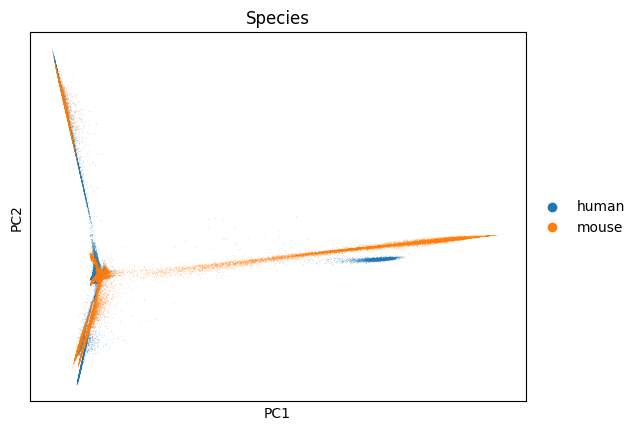

/nfs/research/irene/anaelle/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


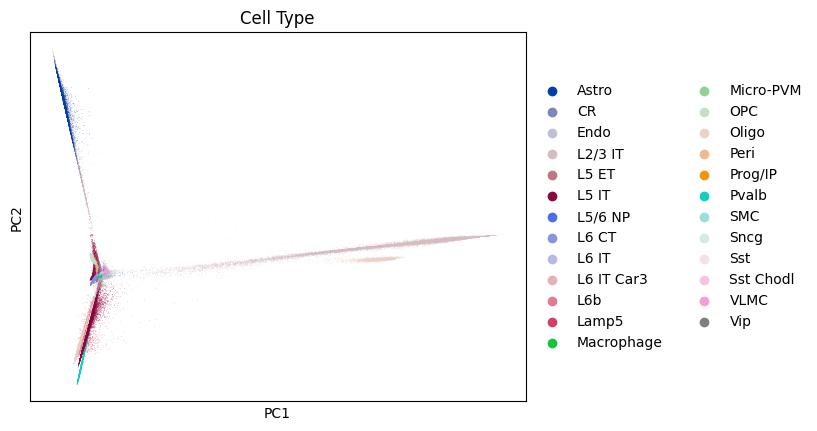

In [50]:
sc.pp.pca(adata)
sc.pl.pca(adata, color="species", title="Species")
sc.pl.pca(adata, color="labels2", title="Cell Type") # The original cell type names
sc.pl.pca(adata, color="labels", title="Cell Type")

/nfs/research/irene/anaelle/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


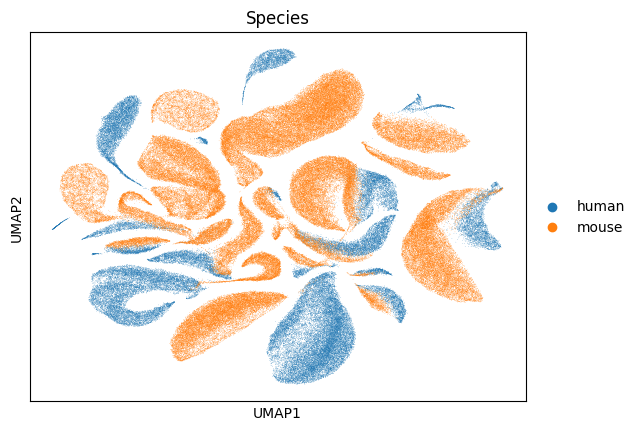

/nfs/research/irene/anaelle/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


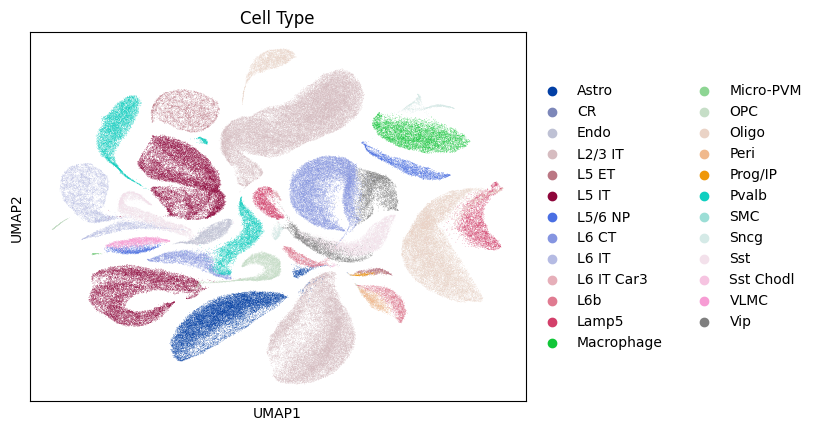

In [51]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="species", title="Species")
sc.pl.umap(adata, color="labels2", title="Cell Type")
sc.pl.umap(adata, color="labels", title="Cell Type")

# Macrogene Differential Expression

With SATURN, we can perform differential expression on macrogenes rather than genes.

In [35]:
with open("saturn_results/test256_data_human_mouse_org_saturn_seed_0_genes_to_macrogenes.pkl", "rb") as f:
    macrogene_weights = pickle.load(f)

In [ ]:
# macrogene weights is a dictionary of (species_{gene name}) : [gene to macrogen weight](1x2000)
macrogene_weights

In [37]:
# Create a copy of the adata with macrogenes as the X values
macrogene_adata = sc.AnnData(adata.obsm["macrogenes"])
macrogene_adata.obs = adata.obs

In [38]:
sc.tl.rank_genes_groups(macrogene_adata, groupby="labels2", groups=["L5 IT"], method="wilcoxon")

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: Astro, CR, Endo, etc.
var_group_labels: L5 IT


/nfs/research/irene/anaelle/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


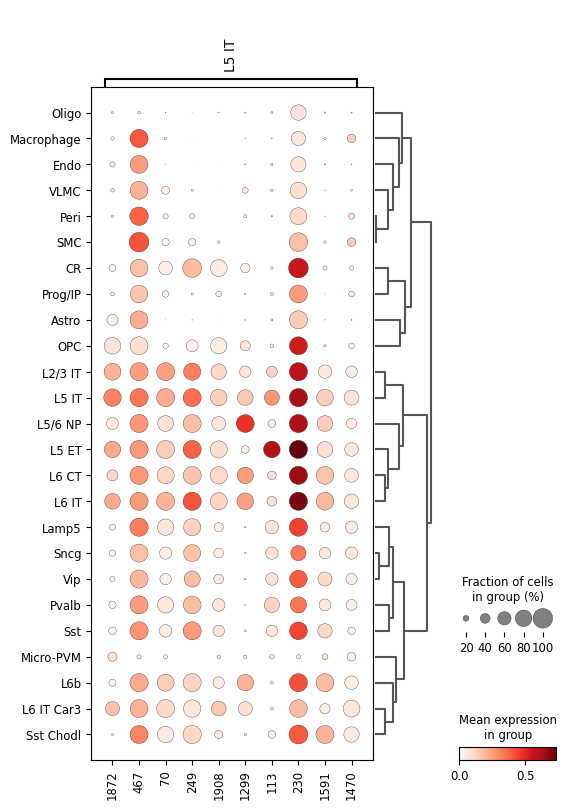

In [39]:
sc.pl.rank_genes_groups_dotplot(macrogene_adata)

In [40]:
l5_de_df = sc.get.rank_genes_groups_df(macrogene_adata, group="L5 IT").head(5)
l5_de_df

,names,scores,logfoldchanges,pvals,pvals_adj
0,1872,170.595963,1.889732,0.0,0.0
1,467,157.684570,0.692964,0.0,0.0
2,70,136.952576,1.101187,0.0,0.0
3,249,125.660568,1.124007,0.0,0.0
4,1908,122.757347,1.068146,0.0,0.0


## Investigate these macrogenes by their top ranked genes

In [41]:
def get_scores(macrogene):
    '''
    Given the index of a macrogene, return the scores by gene for that centroid
    '''
    scores = {}
    for (gene), score in macrogene_weights.items():
        scores[gene] = score[int(macrogene)]
    return scores

In [42]:
# Display the top macrogenes and their highest weights
# NOTE: this will be seed dependent.
for macrogene in l5_de_df["names"]:
    print(f"Macrogene {macrogene}")
    display(pd.DataFrame(get_scores(macrogene).items(), columns=["gene", "weight"])\
            .sort_values("weight", ascending=False)\
            .head(10))

Macrogene 1872


,gene,weight
2418,human_FBXW5,0.579682
2417,human_FBXW4,0.548085
2416,human_FBXW2,0.440289
2415,human_FBXW12,0.391820
751,human_BTRC,0.278086
1175,human_CDRT1,0.271409
5731,human_RAB3GAP2,0.181421
1404,human_CMIP,0.176780
7008,human_TECPR2,0.138599
7750,human_WDR64,0.127828


Macrogene 467


,gene,weight
7758,human_WDTC1,0.119910
4634,human_NEK11,0.115570
6788,human_STK38L,0.113242
240,human_ALG1L2,0.102843
6789,human_STK4,0.097734
4602,human_NDRG4,0.093335
958,human_CBWD6,0.089643
6392,human_SLC25A20,0.088874
678,human_BIRC5,0.088647
5067,human_PANK2,0.088463


Macrogene 70


,gene,weight
5012,human_OTUD3,0.074647
4660,human_NFX1,0.067078
623,human_BAZ1B,0.066170
1187,human_CDYL,0.061183
1185,human_CDY2A,0.060134
1186,human_CDY2B,0.056003
6007,human_RP1,0.052965
1404,human_CMIP,0.048922
1767,human_DCLRE1A,0.048646
13567,mouse_Cdyl,0.047307


Macrogene 249


,gene,weight
15562,mouse_Galnt14,0.086991
8266,mouse_Igf1,0.086649
13638,mouse_Lypd6b,0.082018
3511,human_ITGB3,0.078490
3510,human_ITGB2,0.076423
15478,mouse_Gxylt2,0.069527
14923,mouse_Cdh4,0.067332
8769,mouse_Ntng1,0.065997
14202,mouse_Man1a,0.065774
11975,mouse_Rxfp1,0.064050


Macrogene 1908


,gene,weight
4728,human_NOMO3,0.950629
4726,human_NOMO1,0.283876
4727,human_NOMO2,0.267833
2295,human_FAM171A1,0.023557
564,human_ATRNL1,0.023485
4845,human_NUP210,0.012254
7137,human_TMED5,0.009489
13768,mouse_Ttr,0.006504
14255,mouse_Adamts17,0.005771
14071,mouse_Reck,0.005553
